# Dynamic Breakpoints

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 018-dynamic-breakpoints.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Dynamic Breakpoints
* Sometimes it is useful to **allow the app dynamically interrupt itself**. This is what it is called an internal breakpoint, and can be achieved **using NodeInterrupt**.
* Dynamic Breakpoints have a few specific benefits:
    * you can do it conditionally (from inside a node based on developer-defined logic).
    * you can communicate to the user why it is interrupted (by passing whatever you want to the NodeInterrupt).

* Let's create a graph where a **NodeInterrupt is thrown if the length of the input is longer than 5 characters**:

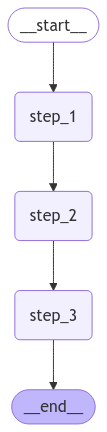

In [6]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

## PAY ATTENTION HERE: Dynamic breakpoint if input length > 5 characters.
def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
# PAY ATTENTION HERE: we are adding the node with the dynamic breakpoint.
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

#### See what happens if we run the graph with an input that's longer than 5 characters:

In [7]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


* If we inspect the graph state at this point, we see that the node set to execute next is step_2:

In [8]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


* We can see that the Interrupt is logged to state:

In [9]:
print(state.tasks)

(PregelTask(id='50772654-1631-2a3c-936b-9df5042066b5', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None, when='during'),), state=None, result=None),)


* **See the error message in the previous response: the response was interrupted because the input had more than 5 characters**.
* Unless state is changed we will be stuck here.

#### Let's now use an input with less than 5 characters

In [10]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbb91e-c3b0-6f9e-8002-ec7417b524e5'}}

In [11]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


* **As you see, now the app runs without interruptions.**

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 018-dynamic-breakpoints.py
* In terminal, make sure you are in the directory of the file and run:
    * python 018-dynamic-breakpoints.py